In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, matthews_corrcoef, roc_auc_score, precision_recall_curve, auc

import os
import random
import gc

In [2]:
# from einops import rearrange, repeat
# import math


# class DSW_embedding(nn.Module):
#     def __init__(self, seg_len, d_model):
#         super(DSW_embedding, self).__init__()
#         self.seg_len = seg_len
#         self.d_model = d_model
#         self.linear = nn.Linear(seg_len * 231, d_model)

#     def forward(self, x):
#         batch, ts_len, ts_dim = x.shape
#         pad_len = (self.seg_len - (ts_len % self.seg_len)) % self.seg_len
#         if pad_len != 0:
#             x = torch.cat([x, torch.zeros(batch, pad_len, ts_dim).to(x.device)], dim=1)
#         seg_num = (ts_len + pad_len) // self.seg_len
#         x_segment = rearrange(x, 'b (seg_num seg_len) d -> b seg_num (seg_len d)', seg_len=self.seg_len)
#         x_embed = self.linear(x_segment)
#         # Reshape to (batch, seg_num * seg_len, d_model)
#         x_embed = x_embed.unsqueeze(2).repeat(1, 1, self.seg_len, 1)
#         x_embed = x_embed.view(batch, -1, self.d_model)
#         return x_embed[:, :ts_len, :]  # Remove the padding

# class SegMerging(nn.Module):
#     def __init__(self, d_model, win_size, norm_layer=nn.LayerNorm):
#         super().__init__()
#         self.d_model = d_model
#         self.win_size = win_size
#         self.linear_trans = nn.Linear(d_model, d_model)
#         self.norm = norm_layer(d_model)

#     def forward(self, x):
#         x = self.norm(x)
#         x = self.linear_trans(x)
#         return x

# class AttentionLayer(nn.Module):
#     def __init__(self, d_model, n_heads, dropout=0.1):
#         super(AttentionLayer, self).__init__()
#         self.n_heads = n_heads
#         self.d_model = d_model
#         self.d_k = d_model // n_heads

#         self.qkv_proj = nn.Linear(d_model, 3 * d_model)
#         self.o_proj = nn.Linear(d_model, d_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, q, k, v):
#         B, L, _ = q.size()
#         qkv = self.qkv_proj(q).chunk(3, dim=-1)
#         q, k, v = [rearrange(x, 'b l (h d) -> b h l d', h=self.n_heads) for x in qkv]

#         scores = torch.einsum('bhld,bhmd->bhlm', q, k) / math.sqrt(self.d_k)
#         attn = scores.softmax(dim=-1)
#         attn = self.dropout(attn)

#         context = torch.einsum('bhlm,bhmd->bhld', attn, v)
#         context = rearrange(context, 'b h l d -> b l (h d)')
#         output = self.o_proj(context)
#         return output

# class CrossEncoder(nn.Module):
#     def __init__(self, d_model, n_heads, d_ff, block_depth, dropout, factor, e_blocks, win_size):
#         super().__init__()
#         self.time_attention = AttentionLayer(d_model, n_heads, dropout)
#         self.dim_sender = AttentionLayer(d_model, n_heads, dropout)
#         self.dim_receiver = AttentionLayer(d_model, n_heads, dropout)
#         self.router = nn.Parameter(torch.randn(e_blocks, factor, d_model))
        
#         self.dropout = nn.Dropout(dropout)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.norm3 = nn.LayerNorm(d_model)
#         self.norm4 = nn.LayerNorm(d_model)
        
#         self.MLP1 = nn.Sequential(nn.Linear(d_model, d_ff),
#                                   nn.GELU(),
#                                   nn.Linear(d_ff, d_model))
#         self.MLP2 = nn.Sequential(nn.Linear(d_model, d_ff),
#                                   nn.GELU(),
#                                   nn.Linear(d_ff, d_model))

#     def forward(self, x):
#         batch, seq_len, d_model = x.shape
#         time_enc = self.time_attention(x, x, x)
#         dim_in = x + self.dropout(time_enc)
#         dim_in = self.norm1(dim_in)
#         dim_in = dim_in + self.dropout(self.MLP1(dim_in))
#         dim_in = self.norm2(dim_in)

#         dim_send = dim_in
#         batch_router = repeat(self.router, 'e_blocks factor d_model -> (repeat e_blocks) factor d_model', repeat=batch)
#         dim_buffer = self.dim_sender(batch_router, dim_send, dim_send)
#         dim_receive = self.dim_receiver(dim_send, dim_buffer, dim_buffer)
#         dim_enc = dim_send + self.dropout(dim_receive)
#         dim_enc = self.norm3(dim_enc)
#         dim_enc = dim_enc + self.dropout(self.MLP2(dim_enc))
#         dim_enc = self.norm4(dim_enc)

#         return dim_enc

# class EncoderOnlyCrossFormer(nn.Module):
#     def __init__(self, seg_len, d_model, num_classes, num_layers, win_size, n_heads, d_ff, e_blocks, dropout=0.1):
#         super(EncoderOnlyCrossFormer, self).__init__()
        
#         # Embedding layer
#         self.embedding = DSW_embedding(seg_len, d_model)
        
#         # Encoder layers
#         self.encoders = nn.ModuleList([
#             CrossEncoder(d_model=d_model, n_heads=n_heads, d_ff=d_ff, block_depth=1, dropout=dropout, factor=5, e_blocks=e_blocks, win_size=win_size) for _ in range(num_layers)
#         ])
        
#         # Segment merging layer
#         self.seg_merge = SegMerging(d_model, win_size)
        
#         # Classification head
#         self.logit = nn.Linear(d_model, num_classes)
#         self.classifier = nn.Sequential(
#             nn.LayerNorm(d_model),
#             self.logit
#         )
        
#     def forward(self, x):
#         # Apply embedding
#         x_embed = self.embedding(x)
        
#         # Pass through each encoder layer
#         for encoder in self.encoders:
#             x_embed = encoder(x_embed)
        
#         # Merge segments
#         x_merged = self.seg_merge(x_embed)
        
#         # Classification head
#         logits = self.classifier(x_merged)
        
#         return logits

In [3]:
from einops import rearrange, repeat
import math


class DSW_embedding(nn.Module):
    def __init__(self, seg_len, d_model):
        super(DSW_embedding, self).__init__()
        self.seg_len = seg_len
        self.d_model = d_model
        self.linear = nn.Linear(seg_len * 231, d_model)

    def forward(self, x):
        batch, ts_len, ts_dim = x.shape
        pad_len = (self.seg_len - (ts_len % self.seg_len)) % self.seg_len
        if pad_len != 0:
            x = torch.cat([x, torch.zeros(batch, pad_len, ts_dim).to(x.device)], dim=1)
        seg_num = (ts_len + pad_len) // self.seg_len
        x_segment = rearrange(x, 'b (seg_num seg_len) d -> b seg_num (seg_len d)', seg_len=self.seg_len)
        x_embed = self.linear(x_segment)
        x_embed = x_embed.unsqueeze(2).repeat(1, 1, self.seg_len, 1)
        x_embed = x_embed.view(batch, -1, self.d_model)
        return x_embed[:, :ts_len, :]


class SegMerging(nn.Module):
    def __init__(self, d_model, win_size, norm_layer=nn.LayerNorm):
        super().__init__()
        self.d_model = d_model
        self.win_size = win_size
        self.linear_trans = nn.Linear(d_model, d_model)
        self.norm = norm_layer(d_model)

    def forward(self, x):
        
        x = self.norm(x)
        x = self.linear_trans(x)
        return x

class AttentionLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_model // n_heads

        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        self.o_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

        # For visualization purposes
        self.scores = None  

    def forward(self, q, k, v):
        B, Lq, _ = q.size()
        _, Lk, _ = k.size()

        qkv = self.qkv_proj(q).chunk(3, dim=-1)
        q, k, v = [rearrange(x, 'b l (h d) -> b h l d', h=self.n_heads) for x in qkv]

        scores = torch.einsum('bhqd,bhkd->bhqk', q, k) / math.sqrt(self.d_k)

        if Lq == Lk:
            causal_mask = torch.tril(torch.ones(Lq, Lk, device=q.device)).unsqueeze(0).unsqueeze(0)
            scores = scores.masked_fill(causal_mask == 0, float('-inf'))

        # store raw scores (before softmax)
        self.scores = scores.detach()  

        attn = self.dropout(scores.softmax(dim=-1))
        self.attn_weights = attn.detach().cpu()  # Store attention weights here

        context = torch.einsum('bhqk,bhkd->bhqd', attn, v)
        context = rearrange(context, 'b h l d -> b l (h d)')
        return self.o_proj(context)

class CrossEncoder(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout, factor, e_blocks):
        super().__init__()
        self.time_attention = AttentionLayer(d_model, n_heads, dropout)
        self.dim_sender = AttentionLayer(d_model, n_heads, dropout)
        self.dim_receiver = AttentionLayer(d_model, n_heads, dropout)

        self.router = nn.Parameter(torch.randn(e_blocks, factor, d_model))

        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)

        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_ff), nn.GELU(), nn.Linear(d_ff, d_model))
        self.MLP2 = nn.Sequential(nn.Linear(d_model, d_ff), nn.GELU(), nn.Linear(d_ff, d_model))

    def forward(self, x):
        time_enc = self.time_attention(x, x, x)
        x = x + self.dropout(time_enc)
        x = self.norm1(x)
        x = x + self.dropout(self.MLP1(x))
        x = self.norm2(x)

        batch_router = repeat(self.router, 'e_blocks factor d_model -> (repeat e_blocks) factor d_model', repeat=x.size(0))

        dim_buffer = self.dim_sender(batch_router, x, x)
        dim_receive = self.dim_receiver(x, dim_buffer, dim_buffer)

        x = x + self.dropout(dim_receive)
        x = self.norm3(x)
        x = x + self.dropout(self.MLP2(x))
        x = self.norm4(x)

        return x

class EncoderOnlyCrossFormer(nn.Module):
    def __init__(self, seg_len, d_model, num_classes, num_layers, n_heads, d_ff, e_blocks, dropout=0.1, win_size=1):
        super().__init__()
        self.embedding = DSW_embedding(seg_len, d_model)
        
        self.encoders = nn.ModuleList([
            CrossEncoder(d_model, n_heads, d_ff, dropout, factor=5, e_blocks=e_blocks)
            for _ in range(num_layers)
        ])
        
        # Include the segment merging layer
        self.seg_merge = SegMerging(d_model, win_size)
        
        # Classification head structure as in the original model
        self.logit = nn.Linear(d_model, num_classes)
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            self.logit
        )

    def forward(self, x):
        x_embed = self.embedding(x)

        for encoder in self.encoders:
            x_embed = encoder(x_embed)

        # segment merging (required for compatibility)
        x_merged = self.seg_merge(x_embed)

        logits = self.classifier(x_merged)
        return logits

In [4]:
import warnings

# Suppress warnings from PyTorch
warnings.filterwarnings("ignore", category=UserWarning)
torch.set_printoptions(profile="default")  # Prevent any potential printing-related warnings
import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Suppress Python warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
model_type = 'Crossformer'

In [6]:
batch_size=1
model_1 = EncoderOnlyCrossFormer(seg_len=1, d_model=36, num_classes=2, num_layers=1, win_size=1, n_heads=2, d_ff=16, e_blocks=1)

In [7]:
# model_path_1 = 'circ_crossformer/testing_Crossformer_Circ_seed_0/model_epoch_40.pth' #model 1
model_path_1 = 'circ_crossformer/circ_best_model/model-causal-circ/model-causal.torch' ## causal model

In [8]:
temp_model = torch.load(model_path_1,map_location=torch.device('cpu'))
# Extract the model state dictionary
model_state_dict = temp_model['model']

In [9]:
# Load the state dictionary into the model
model_1.load_state_dict(model_state_dict)

<All keys matched successfully>

In [10]:
# model1 = model_1.cuda()

In [12]:
model1 = model_1.to('cpu')

In [14]:
# acc_test_per, loss_test_per, output_test_per, target_test_per = predict(test_loader, model1, criterion=nn.CrossEntropyLoss(), args=args_test)

## load data

In [15]:
# # Load the large tensor from file (assumes it's saved in a format compatible with `torch.load`)
# file_path = "circ_crossformer/circ_data_tensors/Circ_test_data.pt"
# big_tensor = torch.load(file_path)  # This loads the tensor into CPU memory

In [16]:
# big_tensor.shape

In [210]:
pid = 1605
# pid = 3737

In [211]:
# ## load labels
label_path   = "circ_crossformer/circ_data_tensors/Circ_test_label.pt"
label_tensor = torch.load(label_path)  # This loads the tensor into CPU memory

In [212]:
label_tensor = label_tensor[pid:pid+1]

In [213]:
label_tensor.shape

torch.Size([1, 2016])

In [214]:
label_tensor[label_tensor == -1] = 0

In [215]:
if pid == 1605:
    data0 = np.load('circ_crossformer/circ_data_tensors/data_1605_best.npy')
elif pid== 3737:
    data0 = np.load('circ_crossformer/circ_data_tensors/data_3737_best.npy')

In [216]:
# data0 = data_tensor=big_tensor[1:2]

In [217]:
data0.shape

(1, 2016, 231)

In [21]:
# data0_np = data0.numpy()

In [22]:
# # Create a figure and subplots
# num_features = filtered_data.shape[1]
# fig, axes = plt.subplots(num_features, 1, figsize=(12, num_features * 0.3), sharex=True)

# # Plot each feature as a separate subplot
# for i in range(num_features):
#     axes[i].plot(range(filtered_data.shape[0]), filtered_data[:, i], linewidth=0.7)
#     axes[i].axis('off')  # Remove axes boundaries

# # Adjust spacing between plots to keep them compact
# plt.subplots_adjust(hspace=0.05)

# # Show the plot
# plt.show()

In [27]:
# print(num_features)

In [28]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Set figure size to make the x-axis longer (increase the width)
# plt.figure(figsize=(12, 1))  # Adjust width (10) and height (5) as needed

# # Plotting the heatmap
# plt.imshow(filtered_data.detach().cpu().numpy().T, cmap='coolwarm', aspect='auto', interpolation='none')
# plt.colorbar()  # Add a color bar for reference
# plt.title("Dataset")
# plt.xlabel("Timesteps")
# plt.ylabel("Features")
# # Remove the figure boundaries (spines)
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # Display the heatmap
# plt.show()

In [181]:
batch = data0#torch.index_select(data_tensor, 2, indexes_of_1_torch)

# print(batch.shape)
# break
# batch.to('cuda')
# batch = batch.cuda()

In [182]:
batch.shape

(1, 2016, 231)

In [183]:
# batch = batch.squeeze()

In [184]:
batch = torch.tensor(batch)

In [29]:
# batch = batch.cuda()

### load baseline data for some methods

In [150]:
baseline = torch.load('circ_crossformer/circ_data_tensors/Circ_baseline_100.pt')

In [151]:
# baseline.shape

In [152]:
baselines_tensor = baseline[:2]

In [153]:
baselines_tensor.shape

torch.Size([2, 2016, 231])

In [154]:
# model1.device

In [155]:
# from captum.attr import IntegratedGradients # Worked on CPU
# from captum.attr import GradientShap        # Worked on CPU
# from captum.attr import DeepLift, DeepLiftShap # works but DeepLiftShap takes a lot of memory # --- DeepLiftShap always require a baseline
# from captum.attr import Lime 
# from captum.attr import Occlusion ## works but slow
# from captum.attr import FeatureAblation works but slow same as occlusion
# from captum.attr import FeaturePermutation ##works


In [156]:
import sys

In [157]:
sys.path.insert(0, "/home/shashank/Desktop/todynet/dtw_tsl_stuff/txai")

In [224]:
# from tint.attr import TemporalIntegratedGradients ## works on cpu gives output of shape xxx #--slow 
# from tint.attr import SequentialIntegratedGradients
from tint.attr import Fit ## workd finally but takes an four hours for a sample
# from tint.attr import Retain

In [219]:
# explainer  = IntegratedGradients(model1)
# explainer  = GradientShap(model1)
# explainer  = DeepLift(model1)
# explainer  = DeepLiftShap(model1)

In [225]:
del explainer

In [226]:
# explainer = TemporalIntegratedGradients(model1)
# explainer = SequentialIntegratedGradients(model1)

In [27]:
# explainer = Occlusion(model1)

In [227]:
explainer = Fit(model1, features=baseline)
# explainer = Retain(features=big_tensor, labels=label_tensor) ##-- get train data from desktop then do this

Init generator with feature size torch.Size([100, 2016, 231])



  | Name | Type                  | Params | Mode 
-------------------------------------------------------
0 | net  | JointFeatureGenerator | 694 K  | train
-------------------------------------------------------
694 K     Trainable params
0         Non-trainable params
694 K     Total params
2.779     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

In [231]:
import pickle

In [232]:
explainer

In [234]:
# with open('circ_crossformer/fit_object_mar14_causal_crossformer.pkl', 'wb') as file:
#     pickle.dump(explainer, file)

In [32]:
# # To load the object back
# with open('retain_explainer.pkl', 'rb') as file:
#     explainer = pickle.load(file)

In [33]:
# explainer_loaded

In [34]:
# final_tensor.shape, val_final_tensor.shape

In [35]:
# data_sample = data_sample_batch = final_tensor[:1]
# label_sample = label[0].unsqueeze(0)
# mask_sample = mask[0].unsqueeze(0)

In [36]:
# data_sample_batch.shape

In [37]:
# explainer = Fit(model1, features=baseline_batch_temp[:1]) 

In [38]:
# attr = explainer.attribute(data_sample) 

In [35]:
# label_tensor.shape

In [36]:
# label_tensor_r = label_tensor.reshape(1,-1).long()

In [37]:
# label_tensor_r.shape

## focus on timestep 199,200 and 201 for record 1
## focus on timestep 1099, 1100 for record 2

In [28]:
# baselines_tensor.shape

In [228]:
batch.shape, baselines_tensor[:].shape

(torch.Size([1, 2016, 231]), torch.Size([2, 2016, 231]))

In [186]:
try:
    del attr
except:
    pass

In [235]:
batch.shape

torch.Size([1, 2016, 231])

In [236]:
# attr = explainer.attribute(batch, target=(1100,1)) #IG
# attr = explainer.attribute(batch, baselines=baselines_tensor, target=(1100,1)) #GradientSHAP
# attr = explainer.attribute(batch, baselines=baselines_tensor, target=(1100,1)) #DeepLIFT and #DeepLiftSHAP
# attr = explainer.attribute(batch, baselines=batch * 0,target=(0,1), n_steps= 10, show_progress=True) #TIG 
# attr_200 = explainer.attribute(batch, target=(200,1),show_progress=True) #SIG ## two remaining 200 and 201: takes 4 hours


attr = explainer.attribute(batch) ## FIT
# attr = explainer.attribute(batch)
# attr = explainer.attribute(batch, target=label_tensor_r)

  0%|          | 0/2015 [00:00<?, ?it/s]

In [69]:
# torch.save(attr_200, 'circ_crossformer/attr_SIG_200.pt') ## two remaining

In [70]:
# attr_201 = explainer.attribute(batch, target=(201,1),show_progress=True) #SIG ## two remaining 200 and 201: takes 4 hours

In [85]:
# attributions = explainer.attribute(batch, sliding_window_shapes = (1,1) ) ##Occlusion

In [86]:
# attr, br = explainer.attribute(data_sample_batch_temp, return_best_ratio=True) 
# attr = explainer.attribute(data_sample_batch_temp) 
# attributions = explainer.attribute(data_sample_batch_temp, sliding_window_shapes = (1,1, 1) ) ##Occlusion

In [87]:
# attr =  explainer.attribute(data_sample_batch_temp, stdevs=0.09, n_samples=5, baselines=baseline_batch_temp, target=0)

In [88]:
# attr

In [204]:
attr.shape

torch.Size([1, 2016, 231])

In [205]:
# attr_sq = torch.squeeze(attr)
attr_sq = torch.squeeze(attr).detach().cpu()

In [206]:
attr_sq

tensor([[-0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-1.8735e-04, -1.7188e-02, -4.6637e-02,  ..., -0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-8.6079e-05, -1.1407e-01, -1.3985e-01,  ..., -0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 4.1423e-06, -3.2880e-07, -5.2186e-07,  ..., -5.4706e-06,
         -2.1487e-06, -0.0000e+00],
        [ 4.5246e-08, -5.8900e-08, -5.8161e-08,  ..., -1.4206e-07,
         -6.5822e-08,  0.0000e+00],
        [ 5.6032e-08, -1.6799e-08,  2.4976e-08,  ..., -2.3096e-07,
         -7.2231e-08,  0.0000e+00]], dtype=torch.float64)

In [207]:
attr_sq.shape

torch.Size([2016, 231])

In [208]:
torch.min(attr_sq), torch.max(attr_sq), torch.mean(attr_sq)

(tensor(-0.2362, dtype=torch.float64),
 tensor(1.3368, dtype=torch.float64),
 tensor(1.0518e-05, dtype=torch.float64))

In [200]:
# torch.save(attr_sq, 'circ_crossformer/attr_IG_1100_causalcrossformer_pid3737.pt')
# torch.save(attr_sq, 'circ_crossformer/attr_GSHAP_1100_causalcrossformer_pid3707.pt')
# torch.save(attr_sq, 'attr_revision/attr_DeepLift_Baseline_1100_causalcrossformer_pid3707.pt')
# torch.save(attr_sq, 'attr_revision/attr_DeepLiftSHAP_Baseline_1100_causalcrossformer_pid3707.pt')

In [223]:
torch.save(attr_sq, 'attr_revision/attr_TIG_C1_pid1605.pt')
# torch.save(attr_sq, 'circ_crossformer/attr_SIG_199.pt') ## two remaining

In [58]:
# torch.save(attr_sq, 'circ_crossformer/attr_FIT.pt') ## two remaining #3 hours 46 mins

In [67]:
# # Compute attributions and approximation error
# attributions = explainer.attribute(data_sample, target=(2015, 1), n_steps=5)

# # Print results to verify
# print("Attributions shape:", attributions.shape)
# print("Attributions:", attributions)

In [68]:
# attributions_original_shape = attributions.permute(0, 3, 2, 1).squeeze(-1)

In [69]:
# attributions_original_shape = attr[0]

In [70]:
# attributions_original_shape.shape

In [71]:
# attr = attributions_original_shape[0]

In [72]:
attr_sq_nff = attr_sq[:, non_flat_features.squeeze()]

| Index   | Algorithms   | source   | WHY NOT Work   |
|---------|--------------|---------|--------------|
| 10      | IntegratedGradients    | captum library | Multi-output Model
| 11      | GradientShap    | captum library | Multi-output Model
| 12      | DeepLift    | captum library |Multi-output Model 
| 12      | DeepLiftSHAP    | captum library |Multi-output Model 
| 1       | TemporalIntegratedGradients    | time interpret library | read doc - it works | 
| 7       | SequentialIntegratedGradients     |time interpret library |Multi-output Model and OOM
|- |- |- |-|
| 2       | AugmentedOcclusion |time interpret library |Works but gives 4032 in the batch one full attr map for each output
| 5       | Feature Ablation     |captum library |
| 6       | Occlusion     |time interpret library | Works but gives 4032 in the batch one full attr map for each output
| 8       | FIT     |time interpret library | generator takes a lot too train
| 9       | RETAIN     |time interpret library | is attention based - unreliable
| 3       | Dynamask     |time interpret library | works
| 4       | Extremal mask     |time interpret library | works
| 13      | LIME    | captum library | not supported for multi-output model
| 14      | Occlusion    | captum and time_interpret library both |Works but gives 4032 in the batch one full attr map for each output

### attention extraction

In [52]:
# Example inference code:
model_1.eval()
with torch.no_grad():
    output = model_1(torch.tensor(data0))  # input_tensor is your data (shape: [batch, T, features])

# Extract attention weights from the first encoder layer (you can choose any)
attention_weights = model_1.encoders[0].time_attention.attn_weights  # shape: [batch, heads, T, T]

In [53]:
attention_weights.shape

torch.Size([1, 2, 2016, 2016])

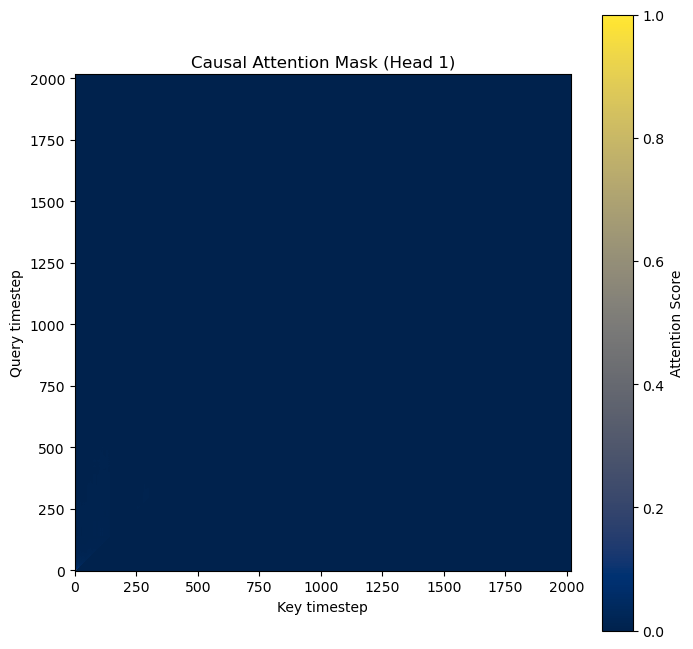

In [54]:
import matplotlib.pyplot as plt

batch_idx = 0  # single batch sample
head_idx = 1   # first attention head (you can also try head_idx=1)

# Extract attention weights for the specified head and batch
attn_matrix = attention_weights[batch_idx, head_idx].numpy()

plt.figure(figsize=(8, 8))
plt.imshow(attn_matrix, cmap='cividis', interpolation='nearest')
plt.colorbar(label='Attention Score')
plt.title('Causal Attention Mask (Head {})'.format(head_idx))
plt.xlabel('Key timestep')
plt.ylabel('Query timestep')
plt.gca().invert_yaxis()
plt.show()

In [38]:
np.min(attn_matrix), np.max(attn_matrix)

(0.0, 1.0)

In [39]:
np.mean(attn_matrix)

0.0004960316

In [42]:
np.var(attn_matrix)

1.8938032e-06

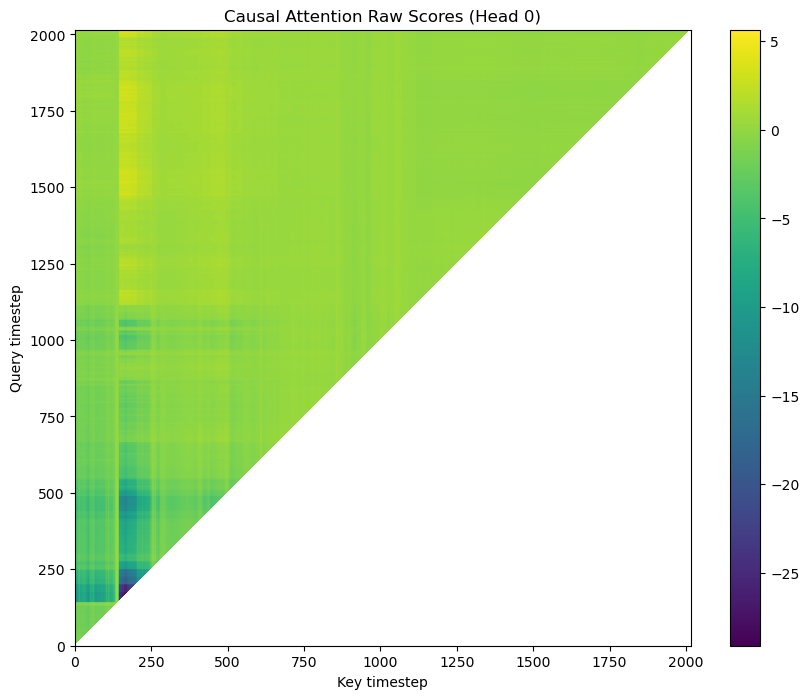

In [55]:
import matplotlib.pyplot as plt

batch_idx = 0
head_idx = 0

# Assuming raw attention scores are stored as 'scores'
raw_scores = model_1.encoders[0].time_attention.scores[batch_idx, head_idx].detach().cpu().numpy()

plt.figure(figsize=(10, 8))
plt.imshow(raw_scores, cmap='viridis')
plt.title("Causal Attention Raw Scores (Head {})".format(head_idx))
plt.xlabel("Key timestep")
plt.ylabel("Query timestep")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

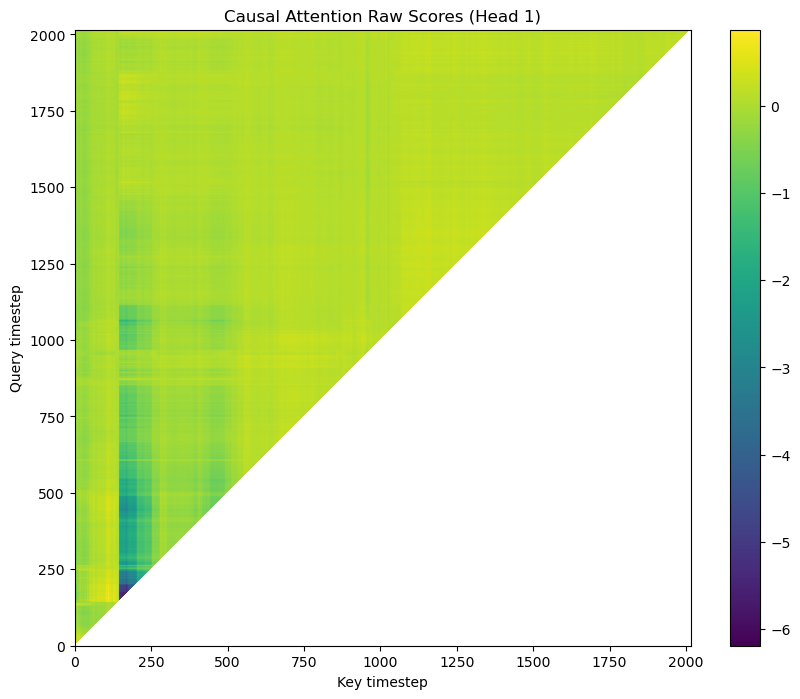

In [56]:
import matplotlib.pyplot as plt

batch_idx = 0
head_idx = 1

# Assuming raw attention scores are stored as 'scores'
raw_scores = model_1.encoders[0].time_attention.scores[batch_idx, head_idx].detach().cpu().numpy()

plt.figure(figsize=(10, 8))
plt.imshow(raw_scores, cmap='viridis')
plt.title("Causal Attention Raw Scores (Head {})".format(head_idx))
plt.xlabel("Key timestep")
plt.ylabel("Query timestep")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

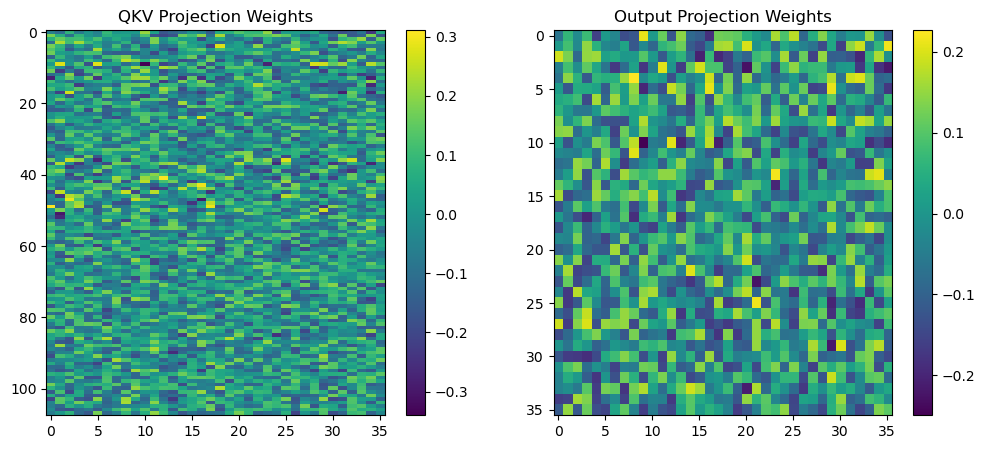

In [57]:
import matplotlib.pyplot as plt

# Extract the learned weight matrices
qkv_weights = model_1.encoders[0].time_attention.qkv_proj.weight.detach().cpu().numpy()
o_proj_weights = model_1.encoders[0].time_attention.o_proj.weight.detach().cpu().numpy()

# Plot the projection weights
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(qkv_weights, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("QKV Projection Weights")

plt.subplot(1, 2, 2)
plt.imshow(o_proj_weights, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Output Projection Weights")

plt.show()
